In [102]:
import pandas as pd
import numpy as np
import matplotlib as plt
from skspatial.objects import LineSegment

In [103]:
# create a square shape
# template = [(-1, -1), (1, -1), (1, 1), (-1 , 1)]
# create a triangle
template = [(-1, -1), (1, 0), (-1, 1)]
# interpolate the shape using numpy

# create a circle template
# template = [(np.cos(theta), np.sin(theta)) for theta in np.linspace(0, 2*np.pi, 36)]



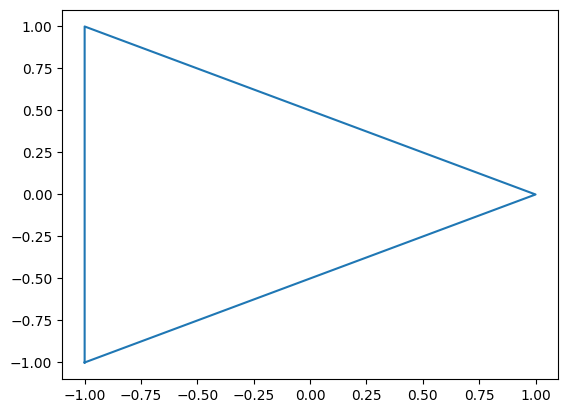

In [104]:
# plot the template shape wrapping around to the first point
plt.pyplot.plot([x for x, y in template] + [template[0][0]], [y for x, y in template] + [template[0][1]])

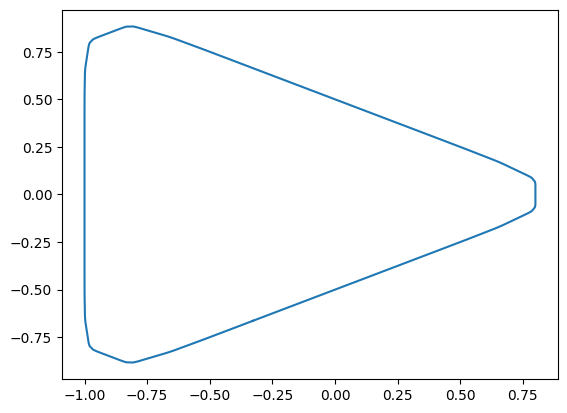

In [105]:
# apply Chaikin's algorithm to the template - corner cuttine
def chaikin(arr, iterations):
    if iterations == 0:
        return arr
    l = len(arr)
    smoothed = []
    for i in range(l):
        x1, y1 = arr[i]
        x2, y2 = arr[(i+1)%l]
        smoothed.append([0.9*x1 + 0.1*x2,0.9*y1 + 0.1*y2])
        smoothed.append([0.1*x1 + 0.9*x2,0.1*y1 + 0.9*y2])
    return chaikin(smoothed, iterations - 1)

template = chaikin(template, 5)
plt.pyplot.plot([x for x, y in template] + [template[0][0]], [y for x, y in template] + [template[0][1]])  

In [106]:
SPACING = 0.2
TURNS = 5
# sweep a line from the origin through 360 degress times the number of turns in 1 degree increments
# and find the intersection points with the template shape
cache = {}
for angle in np.arange(0, 360, 1):
    line = LineSegment(np.array([0, 0]), np.array([10 * np.cos(np.deg2rad(angle)), 10 * np.sin(np.deg2rad(angle))]))
    for i in range(len(template)):
        segment = LineSegment(np.array(template[i]), np.array(template[(i + 1) % len(template)]))
        try:
            intersection = line.intersect_line_segment(segment)
            if intersection is not None:
                cache[angle] = (intersection, segment)
        except ValueError:
            pass

points = []
for angle in np.arange(0, 360 * TURNS, 1):
    intersection, segment = cache[angle % 360]
    offset = SPACING * angle / 360
    vector = np.array(segment.point_a) - np.array(segment.point_b)
    normal = vector / np.linalg.norm(vector)
    # rotate the vector 90 degrees
    normal = np.array([-normal[1], normal[0]])
    # move the intersection point along the normal vector by the spacing
    points.append(intersection + normal * offset)


<AxesSubplot: xlabel='x'>

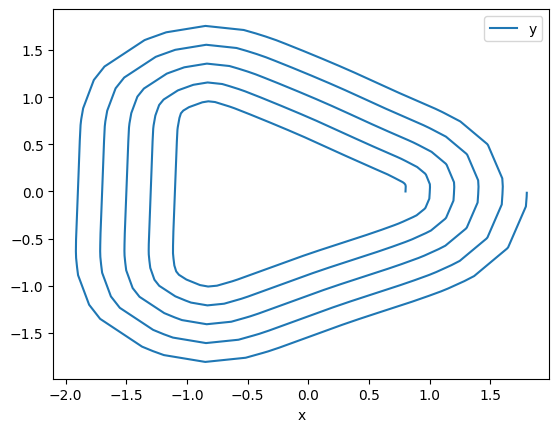

In [107]:
# plot the points
df = pd.DataFrame(points, columns=['x', 'y'])
df.plot.line(x='x', y='y')